In [1]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv, MAX_ACCOUNT_BALANCE
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.policies.dqn import DQNAgent, DefaultConfig
from learning.utils import misc
from learning.policies.discrete_optimal_policy import DiscretePolicyConstructor
from dcc import Parameters, AAV, OAV


import numpy as np
import pickle
import copy
from itertools import product
#import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt
# import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# PLOTTING 

def construct_paths(name, log_num):
    log_path = os.path.join(misc.RESOURCE_ROOT, 'models', name)
    logs = os.listdir(log_path)
#     checkpoints_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'checkpoints')
#     checkpoints = os.listdir(checkpoints_path)
    # print(f"Checkpoints: {checkpoints}")
    models = os.listdir(os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num]))
    model_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num])
    env_path =  os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'env.pkl')
    try:
        buffer_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'buffer.pkl')
    except:
        print('No buffer found.')

#     with open(buffer_path,'rb') as f:
#         buffer = pickle.load(f)
    return model_path

# LOADING

def load_agent(name, lognumber=0):
    log_path = os.path.join(misc.RESOURCE_ROOT, 'models', name)
    logs = os.listdir(log_path)
    print(f"Logs available: {logs}")
    model_path = construct_paths(name, lognumber)
    os.listdir(model_path)
    agent = DQNAgent.load(model_path)
    agent.main_net.compile(loss='MSE')
    return agent

def load_agent_from_path(model_path):
    agent = DQNAgent.load(model_path)
    agent.main_net.compile(loss='MSE')
    return agent

In [2]:
agent = load_agent("4ActionsSplines50KConstrained", 0)

Logs available: ['20201126-004420']
[INFO] [2021-03-04 13:51:05,280] [C:\Projects\credit_collections_rl\learning\resources\models\4ActionsSplines50KConstrained\20201126-004420] - Instantiated class DQNAgent
[WARNING] [2021-03-04 13:51:05,876] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
[WARNING] [2021-03-04 13:51:05,887] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [3]:
def create_map(agent, w_points=80, l_points=80, lam_lim=7, larger_offset=False):
    if larger_offset:
        l = np.linspace(agent.env.observation_space.low[0], lam_lim * 1.2, l_points)
        w = np.linspace(agent.env.observation_space.low[1], agent.env.observation_space.high[1], w_points)

    #     w_normalized = np.linspace(0, 1, w_points)
    #     l_normalized = np.linspace(0, agent.env.observation((lam_lim,100))[0], l_points)
    #     wwn, lln = np.meshgrid(w_normalized, l_normalized)
        ww, ll = np.meshgrid(w, l)
        space_iterator = product(l, w)
        space_product = agent.env.observation(np.array([[i, j] for i, j in space_iterator]))
        predictions = agent.main_net.predict_on_batch(space_product)
        z = np.amax(predictions, axis=1).reshape(l_points, w_points)
        p = np.argmax(predictions, axis=1).reshape(l_points, w_points)
        p[int(p.shape[0]*0.9):, :] = 0.0
    else:

        l = np.linspace(agent.env.observation_space.low[0], lam_lim, l_points)
        w = np.linspace(agent.env.observation_space.low[1], agent.env.observation_space.high[1], w_points)

    #     w_normalized = np.linspace(0, 1, w_points)
    #     l_normalized = np.linspace(0, agent.env.observation((lam_lim,100))[0], l_points)
    #     wwn, lln = np.meshgrid(w_normalized, l_normalized)
        ww, ll = np.meshgrid(w, l)
        space_iterator = product(l, w)
        space_product = agent.env.observation(np.array([[i, j] for i, j in space_iterator]))
        predictions = agent.main_net.predict_on_batch(space_product)
        z = np.amax(predictions, axis=1).reshape(l_points, w_points)
        p = np.argmax(predictions, axis=1).reshape(l_points, w_points)
    return  ww, ll, p, z
#ww, ll, aa, z = create_map(agent)
ww, ll, p, z = create_map(agent, w_points=388, l_points=399, lam_lim=7)

[WARNING] [2021-03-04 13:51:10,091] [tensorflow] - AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x000001E282F9BB88> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [4]:
p.shape

(399, 388)

In [5]:
ww, ll, p, z = create_map(agent, w_points=388, l_points=399, lam_lim=7)

In [6]:
ww, ll, p, z = create_map(agent, w_points=388, l_points=399, lam_lim=7, larger_offset=True)

In [7]:
%%timeit
ww, ll, p, z = create_map(agent, w_points=200, l_points=100, lam_lim=7)

406 ms ± 4.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'Simplest default with labels')

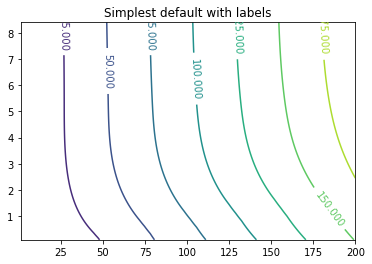

In [8]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

c:\users\markm\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


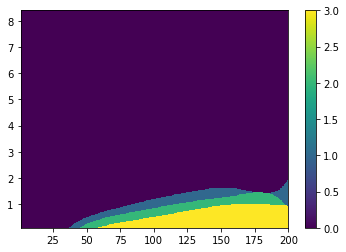

In [9]:
plt.pcolor(ww, ll, p)
plt.colorbar()
plt.show()

In [10]:
import math

def t_equation(lambda_start, lhat, params):
    # equation for duration to reach a holding region
    try:
        numerator = (lambda_start - params.lambdainf)
        denominator = (lhat - params.lambdainf)

        if lambda_start < lhat:
            return 0
        elif denominator < 0:
            return np.NaN
        else:
            t = 1 / params.kappa * \
                np.log(numerator / denominator)
            return t
    except:
        print('warning')
        print(f'Numerator {(lambda_start - params.lambdainf)}')
        print(f'Denominator {(lhat) - params.lambdainf}')
        
def next_arrival(t_to_sustain, l, params):
    # generates interarrival times
    flag_finished = False
    s = 0
    # t_to_sustain = t_equation(l, lhat, params)
    relative_repayment = 0.0
    while not flag_finished:
        lstar = l
        w = -np.log(np.random.rand()) / lstar
        s = s + w
        d = np.random.rand()
        if d * lstar <= drift(s, l, params):
            # arrival
            relative_repayment = params.sample_repayment()[0]
            if np.isnan(t_to_sustain):
                pass
            elif s > t_to_sustain:
                relative_repayment = 0.0
                s = t_to_sustain
            flag_finished = True
    return relative_repayment, s
        
def drift(s, lambda_start, params):
    # deterministic draft
    return params.lambdainf + (lambda_start - params.lambdainf) * np.exp(-params.kappa * s)

def round_decimals_up(number:float, decimals:int=2):
    """
    Returns a value rounded up to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.ceil(number)
    
    if np.isnan(number):
        res= np.NaN
    else:
        factor = 10 ** decimals
        res = math.ceil(number * factor) / factor

    return res

In [11]:
params = agent.env.params
next_arrival(1.0, 1, params)

(0.21921567755396526, 0.17707202563589539)

In [12]:
t_equation(2.0, 1.0, agent.env.params)

1.0674491454717445

In [13]:
round_decimals_up(3.172065784643304e-16, 5)

1e-05

(1.0, 150.0)
Current action is not zero.
(1.5, 150.0)
Current action is not zero.
(1.7, 150.0)
lhat:1.6223618102620296
t t a: 0.07106
Arr time:0.07106
(1.6223597973660413, 150.0)
Current action is not zero.
(1.8223597973660413, 150.0)
lhat:1.6223618102620296
t t a: 0.17634
Arr time:0.17634
(1.622353245896216, 150.0)
Current action is not zero.
(1.822353245896216, 150.0)
lhat:1.6223618102620296
t t a: 0.17633
Arr time:0.17633
(1.6223581116758747, 150.0)
Current action is not zero.
(1.8223581116758747, 150.0)
lhat:1.6223618102620296
t t a: 0.17634
Arr time:0.09928843948997214
ARRIVAL
(1.8740700950585396, 105.79381730750248)
lhat:1.267839197260351
t t a: 0.59732
Arr time:0.5166602851099675
ARRIVAL
(1.6753892547004985, 38.14540206368605)
lhat:0.16256281554923585
t t a: 4.6087
Arr time:0.36831320285532326
ARRIVAL
(1.7235729864773537, 8.680769576415265)
lhat:0
t t a: nan
Arr time:0.45216546537606306
ARRIVAL
(1.3539523018437505, 7.797388615744067)
lhat:0
t t a: nan
Arr time:0.1347585052938739

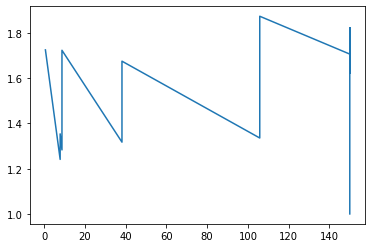

In [17]:
# PRICER HERE
# policy_map = p.copy()
policy_map = p.copy()
w_vec = ww[0, :]
l_vec = ll[:, 0]
action_bins = agent.env.env.action_bins

params = agent.env.params

start_state = np.array([1.0, 150.0], dtype='float32')
current_w = start_state[1].copy()
current_l = start_state[0].copy()
current_time = 0

# This will be evaluated in a loop
reward = 0.0
cost = 0.0

# FOR PLOTTING
print((current_l, current_w))
lams = [current_l]
ws = [current_w]

while current_w > 1.0:
    
    w_ind = np.digitize(current_w, w_vec, right=True)
    l_slice = policy_map[:, w_ind]
    slice_index = np.digitize(current_l, l_vec, right=True)
    current_action_type = l_slice[slice_index]
    current_action = action_bins[current_action_type]

    # if the current action is different from 0
    # apply the action
    if current_action != 0.0:
        current_l = current_l + current_action * params.delta2
        cost += current_action * params.c
        print('Current action is not zero.')
        print((current_l, current_w))
        ws.append(current_w)
        lams.append(current_l)

    else:
#         closest_action_index = l_slice[(l_slice <= current_w) & (l_slice > 0)][-1]
#         closest_action = action_bins[l_hat_type]

        lhat_slice = l_vec[(l_vec <= current_l) & (l_slice > 0)]
        if lhat_slice.shape[0] > 0:
            lhat = lhat_slice[-1]
        else:
            lhat = 0
        print(f'lhat:{lhat}')

#         # plot the w profile slice
#         fig, ax = plt.subplots()
#         ax.plot(l_vec, l_slice)
#         ax.axvline(current_l, color='red', linestyle='--')
#         ax.set_xlabel(r'$\lambda$')
#         ax.set_ylabel('Actions scheduled')

        time_to_action = round_decimals_up(t_equation(current_l, lhat, params), 5)
        print(f't t a: {time_to_action}')
        
        relative_repayment, arr_time = next_arrival(time_to_action, current_l, params)
        print(f'Arr time:{arr_time}')
        current_time += arr_time
        current_l = drift(arr_time, current_l, params)
        ws.append(current_w)
        lams.append(current_l)
        
        if relative_repayment > 0.0:
            reward += np.exp(-params.rho * current_time) * relative_repayment * current_w
            current_w = current_w * (1 - relative_repayment)
            current_l = current_l + relative_repayment * params.delta11 + params.delta10
            print('ARRIVAL')
        print((current_l, current_w))
        ws.append(current_w)
        lams.append(current_l)

    

plt.plot(ws, lams)

In [18]:
from dask import delayed, compute
import joblib
from multiprocessing import cpu_count

def single_collection(start_state, ww, ll, policy_map, params, action_bins):
    w_vec = ww[0, :]
    l_vec = ll[:, 0]

    current_w = start_state[1].copy()
    current_l = start_state[0].copy()
    current_time = 0

    # This will be evaluated in a loop
    reward = 0.0
    cost = 0.0


    while current_w > 1.0:

        w_ind = np.digitize(current_w, w_vec, right=True)
        l_slice = policy_map[:, w_ind]
        current_action_type = l_slice[np.digitize(current_l, l_vec, right=True)]
        current_action = action_bins[current_action_type]


        if current_action != 0.0:
            current_l = current_l + current_action * params.delta2
            cost += current_action * params.c
        else:


            lhat_slice = l_vec[(l_vec <= current_l) & (l_slice > 0)]
            if lhat_slice.shape[0] > 0:
                lhat = lhat_slice[-1]
            else:
                lhat = 0



            time_to_action = round_decimals_up(t_equation(current_l, lhat, params), 5)

            relative_repayment, arr_time = next_arrival(time_to_action, current_l, params)
            current_time += arr_time
            current_l = drift(arr_time, current_l, params)

            if relative_repayment > 0.0:
                reward += np.exp(-params.rho * current_time) * relative_repayment * current_w
                current_w = current_w * (1 - relative_repayment)
                current_l = current_l + relative_repayment * params.delta11 + params.delta10
                
    return reward - cost

def value_account_parallel(account, ww, ll, p, params, action_bins, n_iterations=1000):
#     tasks = []
#     for _ in range(n_iterations):
#         tasks.append(single_collection(account, ww, ll, p, params))
    workers = cpu_count() - 2
    rest = joblib.Parallel(n_jobs=workers)(joblib.delayed(single_collection)(account, ww, ll, p, params, action_bins) for i in range(n_iterations))  
    return rest

def value_account(account, ww, ll, p, params, action_bins, n_iterations=1000):
    vals = np.zeros(n_iterations, dtype='float32')
    for i in range(n_iterations):
        vals[i] = single_collection(account, ww, ll, p, params, action_bins)
    return vals

In [19]:
cpu_count()

12

In [20]:
params = agent.env.params

acc = np.array([0.2, 200], dtype='float32')
single_collection(acc, ww, ll, p, params, agent.env.env.action_bins)

136.41292165527298

In [21]:
%%timeit
single_collection(acc, ww, ll, p, params, agent.env.env.action_bins)

671 µs ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
autonomous_p = np.zeros_like(ww,dtype='int32')

In [23]:
%%timeit
value_account_parallel(acc, ww, ll, autonomous_p, params, agent.env.env.action_bins, n_iterations=10000)

2.27 s ± 46.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit
value_account(acc, ww, ll, autonomous_p, params, agent.env.env.action_bins, n_iterations=10000)

2.67 s ± 20.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
np.mean(value_account_parallel(acc, ww, ll, autonomous_p, params, agent.env.env.action_bins, n_iterations=10000))

66.16051181088801

In [26]:
aav = AAV(params)
aav.u(0.2, 200)

[INFO] [2021-03-04 13:58:00,107] [AAV] - Instantiated @ AAV


-67.2505022779574

Pricing degenerato policy that does not have a no action in the lhat slice

In [27]:
ww.shape

(399, 388)

In [28]:
degenerate_p = np.zeros_like(ww,dtype='int32')
degenerate_p[:, 300:] = 1

c:\users\markm\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


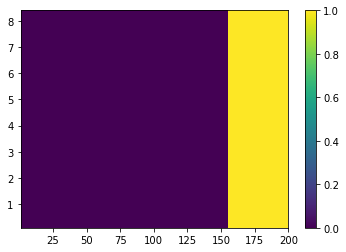

In [31]:
plt.pcolor(ww, ll, degenerate_p)
plt.colorbar()
plt.show()

In [32]:
np.mean(policy_pricer.value_account(np.array([1.0, 199.], dtype='float32'), ww, ll, degenerate_p, params, agent.env.env.action_bins, n_iterations=10000))

NameError: name 'policy_pricer' is not defined

### NUMBA SPEEDUP

In [247]:
import numba
from numba.experimental import jitclass
from numba import int32, float32, float64

In [248]:
spec = [
    ('lambdainf', float64),
    ('kappa', float64),
    ('delta10', float64),
    ('delta11', float64),
    ('delta2', float64),
    ('c', float64)# a simple scalar field         # an array field
]

@jitclass(spec)
class ParamsNumba(object):
    def __init__(self, lambdainf, kappa, delta10, delta11, delta2, c):
        self.lambdainf = lambdainf
        self.kappa = kappa
        self.delta10 = delta10
        self.delta11 = delta11
        self.delta2 = delta2
        self.c = c


In [249]:
paramsnumba = ParamsNumba(params.lambdainf, params.kappa, params.delta10, params.delta11, params.delta2, params.c)

In [263]:
@numba.jit
def t_equation(lambda_start, lhat, params):
    # equation for duration to reach a holding region
    try:
        numerator = (lambda_start - params.lambdainf)
        denominator = (lhat - params.lambdainf)

        if lambda_start < lhat:
            return 0
        elif denominator < 0:
            return np.NaN
        else:
            t = 1 / params.kappa * \
                np.log(numerator / denominator)
            return t
    except:
        print('warning')
#         print(f'Numerator {(lambda_start - params.lambdainf)}')
#         print(f'Denominator {(lhat) - params.lambdainf}')

@numba.jit
def next_arrival(t_to_sustain, l, params):
    # generates interarrival times
    flag_finished = False
    s = 0
    # t_to_sustain = t_equation(l, lhat, params)
    relative_repayment = 0.0
    while not flag_finished:
        lstar = l
        w = -np.log(np.random.rand()) / lstar
        s = s + w
        d = np.random.rand()
        if d * lstar <= drift(s, l, params):
            # arrival
            relative_repayment = params.sample_repayment()[0]
            if np.isnan(t_to_sustain):
                pass
            elif s > t_to_sustain:
                relative_repayment = 0.0
                s = t_to_sustain
            flag_finished = True
    return relative_repayment, s

@numba.jit
def drift(s, lambda_start, params):
    # deterministic draft
    return params.lambdainf + (lambda_start - params.lambdainf) * np.exp(-params.kappa * s)

@numba.jit
def round_decimals_up(number:float, decimals:int=2):
    """
    Returns a value rounded up to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.ceil(number)
    
    if np.isnan(number):
        res= np.NaN
    else:
        factor = 10 ** decimals
        res = math.ceil(number * factor) / factor

    return res

@numba.jit
def single_collection(start_state, ww, ll, policy_map, params, action_bins):
    w_vec = ww[0, :]
    l_vec = ll[:, 0]

    current_w = start_state[1]
    current_l = start_state[0]
    current_time = 0

    # This will be evaluated in a loop
    reward = 0.0
    cost = 0.0


    while current_w > 1.0:

        w_ind = np.digitize(current_w, w_vec, right=True)
        l_slice = policy_map[:, w_ind]
        current_action_type = l_slice[np.digitize(current_l, l_vec, right=True)]
        current_action = action_bins[current_action_type]


        if current_action != 0.0:
            current_l = current_l + current_action * params.delta2
            cost += current_action * params.c
        else:


            lhat_slice = l_vec[(l_vec <= current_l) & (l_slice > 0)]
            if lhat_slice.shape[0] > 0:
                lhat = lhat_slice[-1]
            else:
                lhat = 0



            time_to_action = round_decimals_up(t_equation(current_l, lhat, params), 5)

            relative_repayment, arr_time = next_arrival(time_to_action, current_l, params)
            current_time += arr_time
            current_l = drift(arr_time, current_l, params)

            if relative_repayment > 0.0:
                reward += np.exp(-params.rho * current_time) * relative_repayment * current_w
                current_w = current_w * (1 - relative_repayment)
                current_l = current_l + relative_repayment * params.delta11 + params.delta10
                
    return reward - cost

In [264]:
drift(0.1, 1.0, paramsnumba)

0.9391544379153535

In [265]:
acc = np.array([0.5, 10], dtype='float64')

In [266]:
single_collection(acc, ww, ll, p, paramsnumba, agent.env.env.action_bins)

[INFO] [2021-02-25 11:58:28,826] [numba.core.transforms] - finding looplift candidates
[INFO] [2021-02-25 11:58:29,101] [numba.core.transforms] - finding looplift candidates


<ipython-input-263-72ae59bf0a15>:69: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "single_collection" failed type inference due to: No implementation of function Function(<function digitize at 0x000001F4480281F8>) found for signature:
 
 >>> digitize(float64, array(float64, 1d, C), right=Literal[bool](True))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload of function 'digitize': File: numba\np\arraymath.py: Line 3584.
        With argument(s): '(float64, array(float64, 1d, C), right=bool)':
       No match.

During: resolving callee type: Function(<function digitize at 0x000001F4480281F8>)
During: typing of call at <ipython-input-263-72ae59bf0a15> (85)


File "<ipython-input-263-72ae59bf0a15>", line 85:
def single_collection(start_state, ww, ll, policy_map, params, action_bins):
    <source elided>

        w_ind = np.digitize(current_w, w_vec, right=True)
        ^

  @numba.jit
<ip

[INFO] [2021-02-25 11:58:31,447] [numba.core.transforms] - finding looplift candidates


<ipython-input-263-72ae59bf0a15>:49: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "round_decimals_up" failed type inference due to: Untyped global name 'isinstance': Cannot determine Numba type of <class 'builtin_function_or_method'>

File "<ipython-input-263-72ae59bf0a15>", line 54:
def round_decimals_up(number:float, decimals:int=2):
    <source elided>
    """
    if not isinstance(decimals, int):
    ^

  @numba.jit


[INFO] [2021-02-25 11:58:31,752] [numba.core.transforms] - finding looplift candidates


c:\users\markm\.conda\envs\tf2-gpu\lib\site-packages\numba\core\object_mode_passes.py:152: NumbaWarning: Function "round_decimals_up" was compiled in object mode without forceobj=True.

File "<ipython-input-263-72ae59bf0a15>", line 50:
@numba.jit
def round_decimals_up(number:float, decimals:int=2):
^

  state.func_ir.loc))
c:\users\markm\.conda\envs\tf2-gpu\lib\site-packages\numba\core\object_mode_passes.py:162: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<ipython-input-263-72ae59bf0a15>", line 50:
@numba.jit
def round_decimals_up(number:float, decimals:int=2):
^

  state.func_ir.loc))
<ipython-input-263-72ae59bf0a15>:21: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because F

AttributeError: 'ParamsNumba' object has no attribute 'sample_repayment'

In [226]:
%%timeit
single_collection(acc, ww, ll, p, params, agent.env.env.action_bins)

[INFO] [2021-02-25 11:46:48,615] [numba.core.transforms] - finding looplift candidates


<ipython-input-225-3fd8750d202d>:69: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "single_collection" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-225-3fd8750d202d> (71)

File "<ipython-input-225-3fd8750d202d>", line 71:
def single_collection(start_state, ww, ll, policy_map, params, action_bins):
    w_vec = ww[0, :]
    ^

  @numba.jit
<ipython-input-225-3fd8750d202d>:69: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "single_collection" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-225-3fd8750d202d>", line 83:
def single_collection(start_state, ww, ll, policy_map, params, action_bins):
    <source elided>

    while current_w > 1.0:
    ^

  @numba.jit
c:\users\markm\.conda\envs\tf2-gpu\lib\site-packages\numba\core\object_mode_passes.py:152:

264 µs ± 78.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
